In [1]:
import pandas as pd 
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
import klib
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format ='{:,.3f}'.format

In [3]:
os.chdir(r'C:\Users\lanmo\Downloads\playground-series-s4e7')

In [4]:
df = pd.read_csv('train.csv',index_col = 0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


# Взглянем на размеры датасета 

In [6]:
print(f'train shape {df.shape}')

train shape (11504798, 11)


# Проверка на пустые значения

In [7]:
df.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

# Взглянем на основные описательные статистики

In [8]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,"11,504,798.000","11,504,798.000","11,504,798.000","11,504,798.000","11,504,798.000","11,504,798.000","11,504,798.000","11,504,798.000"
mean,38.384,0.998,26.419,0.463,"30,461.370",112.425,163.898,0.123
std,14.993,0.044,12.992,0.499,"16,454.745",54.036,79.980,0.328
min,20.000,0.000,0.000,0.000,"2,630.000",1.000,10.000,0.000
25%,24.000,1.000,15.000,0.000,"25,277.000",29.000,99.000,0.000
50%,36.000,1.000,28.000,0.000,"31,824.000",151.000,166.000,0.000
75%,49.000,1.000,35.000,1.000,"39,451.000",152.000,232.000,0.000
max,85.000,1.000,52.000,1.000,"540,165.000",163.000,299.000,1.000


In [9]:
df.describe(include = 'object')

,Gender,Vehicle_Age,Vehicle_Damage
count,11504798,11504798,11504798
unique,2,3,2
top,Male,1-2 Year,Yes
freq,6228134,5982678,5783229


In [12]:
df_frac = df.sample(frac = 0.1)

In [10]:
df_with_dum = pd.get_dummies(df, columns = df.sample(frac = 0.1).select_dtypes('object').columns,drop_first=True,dtype=int)

<Axes: xlabel='Vintage', ylabel='Annual_Premium'>

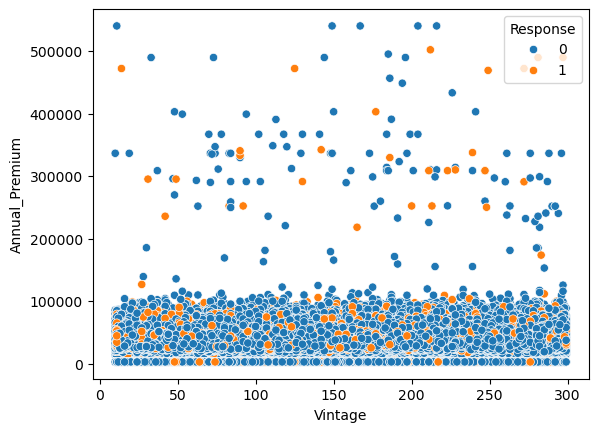

In [13]:
sns.scatterplot(x = 'Vintage',y = 'Annual_Premium',hue='Response', data=df_frac)

<Axes: xlabel='Response', ylabel='Annual_Premium'>

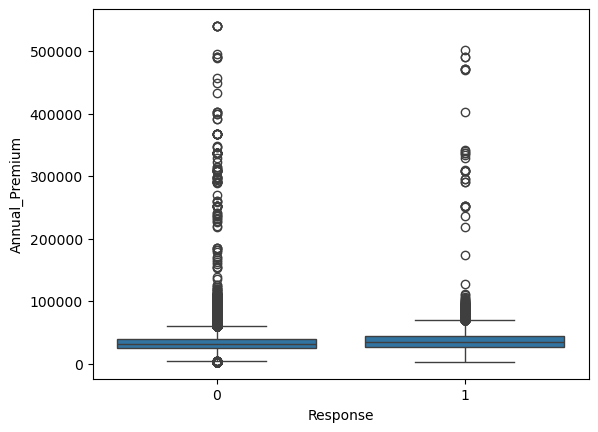

In [14]:
sns.boxplot(y = 'Annual_Premium',x = 'Response',data = df_frac)

<Axes: xlabel='Annual_Premium', ylabel='Count'>

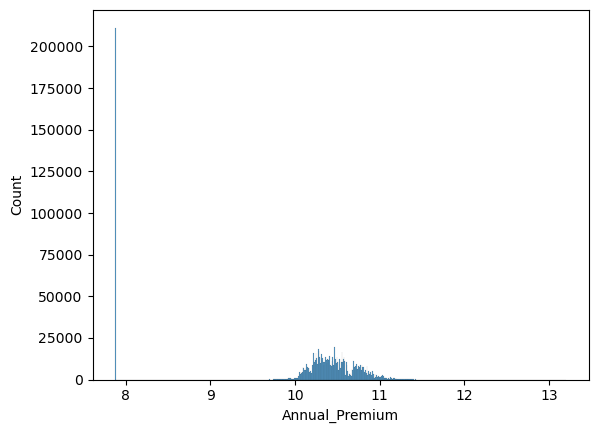

In [15]:
sns.histplot(np.log(df_frac.Annual_Premium+1))

In [16]:
df_with_dum['log_annual_prem'] = np.log(df_with_dum.Annual_Premium)
df_with_dum.drop('Annual_Premium',axis = 1,inplace = True)

# Проверка на категориальность 

In [17]:
for i in ['Region_Code','Policy_Sales_Channel']:
    print(f'unique {i} = {len(df.Region_Code.unique())}')

unique Region_Code = 54
unique Policy_Sales_Channel = 54


<Axes: xlabel='Region_Code', ylabel='Count'>

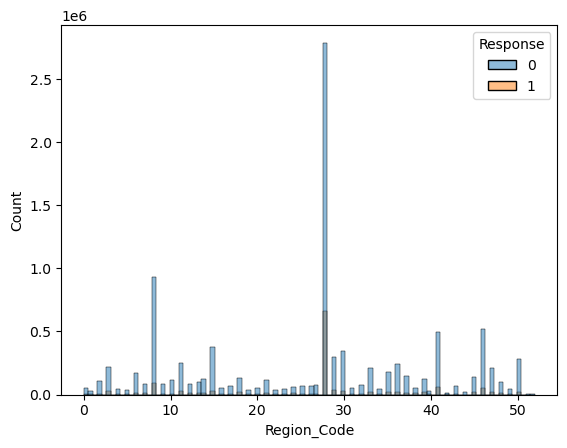

In [18]:
sns.histplot(df_with_dum,x = 'Region_Code',hue = 'Response',bins = 100)

In [19]:
pd.DataFrame(df_with_dum.groupby(['Region_Code','Response']).Response.count()).reset_index(level = ['Region_Code']).loc[0,].shape

(54, 2)

# Есть аномальное наблюдение 39.2 с 1 параметром, скорее всего это выброс поэтому выкенем 

In [20]:
df_with_dum.drop(df_with_dum[df_with_dum.Region_Code == 39.2].index,axis = 0,inplace = True)

In [21]:
zero = pd.DataFrame(df_with_dum.groupby(['Region_Code','Response']).Response.count()).reset_index(level = ['Region_Code']).loc[0,]
one = pd.DataFrame(df_with_dum.groupby(['Region_Code','Response']).Response.count()).reset_index(level = ['Region_Code']).loc[1,]

In [22]:
pd.DataFrame(df_with_dum.groupby(['Region_Code','Response']).Response.count()).reset_index(level = ['Region_Code']).loc[1,].shape

(53, 2)

In [23]:
our = zero.merge(one,on = 'Region_Code',suffixes = ['_0','_1'])

In [24]:
our['dol_Region_Code'] = our.Response_0/our.Response_1

In [25]:
df1 = df_with_dum.merge(our[['Region_Code','dol_Region_Code']],on = 'Region_Code')

<Axes: xlabel='Policy_Sales_Channel', ylabel='Count'>

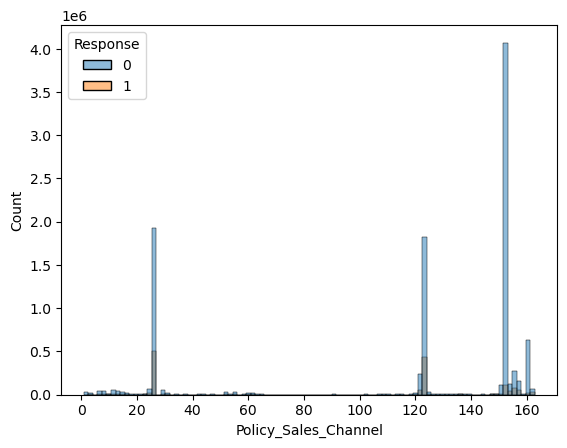

In [26]:
sns.histplot(df_with_dum,x = 'Policy_Sales_Channel',hue = 'Response',bins = 100)

In [27]:
zero_polic = pd.DataFrame(df_with_dum.groupby(['Policy_Sales_Channel','Response']).Response.count()).reset_index(level = ['Policy_Sales_Channel']).loc[0,]
one_polic = pd.DataFrame(df_with_dum.groupby(['Policy_Sales_Channel','Response']).Response.count()).reset_index(level = ['Policy_Sales_Channel']).loc[1,]

In [28]:
print(f'{zero_polic.shape} - zero\n {one_polic.shape} - one')

(152, 2) - zero
 (136, 2) - one


In [29]:
our_polic = zero_polic.merge(one_polic,how = 'outer',on = 'Policy_Sales_Channel',suffixes = ['_0','_1'])

In [30]:
our_ploic = our_polic.fillna(0)
our_ploic.head()

,Policy_Sales_Channel,Response_0,Response_1
0,1.000,32147,813.000
1,2.000,3,3.000
2,3.000,9801,"4,265.000"
3,4.000,10658,"2,626.000"
4,5.000,1,0.000


In [31]:
our_ploic['sum1'] = our_ploic.Response_0 + our_ploic.Response_1
our_ploic['malo_nablud'] = our_ploic.sum1.map(lambda x : 0 if x < 10000 else np.nan)

In [32]:
our_ploic.loc[our_ploic['malo_nablud'].isna(), 'malo_nablud'] = our_ploic.loc[our_ploic['malo_nablud'].isna(), 'Response_0'] / our_ploic.loc[our_ploic['malo_nablud'].isna(), 'Response_1']

In [33]:
our_ploic.isna().sum()

Policy_Sales_Channel    0
Response_0              0
Response_1              0
sum1                    0
malo_nablud             0
dtype: int64

In [34]:
df1 = df1.merge(our_ploic[['Policy_Sales_Channel','malo_nablud']],on ='Policy_Sales_Channel')

<Axes: xlabel='Vintage', ylabel='Count'>

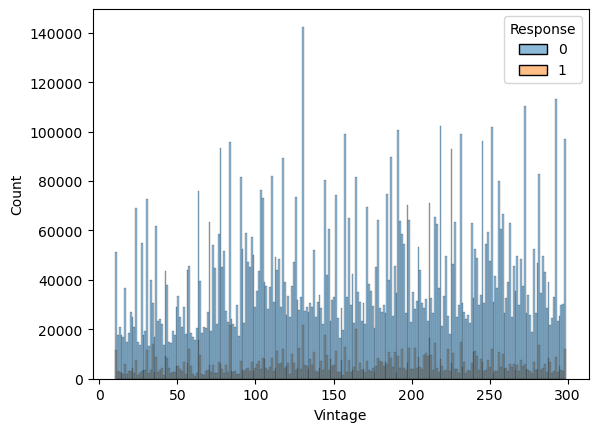

In [35]:
sns.histplot(data = df1, x = 'Vintage',hue = 'Response')

In [36]:
zero_Vintage = pd.DataFrame(df1.groupby(['Vintage','Response']).Response.count()).reset_index(level = ['Vintage']).loc[0,]
one_Vintage = pd.DataFrame(df1.groupby(['Vintage','Response']).Response.count()).reset_index(level = ['Vintage']).loc[1,]
our_Vintage = zero_Vintage.merge(one_Vintage,how = 'outer',on = 'Vintage',suffixes = ['_0','_1'])

In [37]:
our_Vintage['our_Vintage'] = our_Vintage.Response_0/our_Vintage.Response_1

In [38]:
df1 = df1.merge(our_Vintage[['Vintage','our_Vintage']],on = 'Vintage')

In [39]:
df1.drop(['Region_Code','Policy_Sales_Channel','Vintage'],axis = 1,inplace = True)

In [40]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
df2 = pd.DataFrame(scal.fit_transform(df1.drop('Response',axis=1)),columns=df1.drop('Response',axis=1).columns)

# Работа с тестом

In [41]:
test = pd.read_csv('test.csv',index_col = 'id')

In [42]:
tes_dum = pd.get_dummies(test, columns = test.sample(frac = 0.1).select_dtypes('object').columns,drop_first=True,dtype=int)

In [43]:
tes_dum['log_annual_prem'] = np.log(tes_dum.Annual_Premium)
tes_dum.drop('Annual_Premium',axis = 1,inplace = True)

In [44]:
tes_dum['tes_dum_index'] = tes_dum.index

In [45]:
df1_test = tes_dum.merge(our[['Region_Code','dol_Region_Code']],on = 'Region_Code',how ='left')

In [46]:
df1_test = df1_test.merge(our_ploic[['Policy_Sales_Channel','malo_nablud']],on ='Policy_Sales_Channel',how = 'left')


In [47]:
df1_test.loc[[2078459,5965690],'malo_nablud'] = 0
df1_test.loc[7109272,'malo_nablud'] = 10.946

In [48]:
df1_test.drop(['Region_Code','Policy_Sales_Channel'],inplace= True,axis = 1)

In [49]:
df1_test = df1_test.merge(our_Vintage[['Vintage','our_Vintage']],on = 'Vintage',how = 'left')

In [50]:
df1_test.drop('Vintage',axis = 1,inplace = True)

In [51]:
df1_test = (df1_test
.set_index('tes_dum_index')
.sort_index())

In [52]:
columns = df1_test.columns
index = df1_test.index

In [53]:
df1_test = pd.DataFrame(scal.transform(df1_test),columns = columns, index = index)

# Kfold

In [ ]:
y = df1.Response

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = 3
strac = StratifiedKFold(n_splits = kfold, shuffle=True,random_state = 12)

In [ ]:
prdicts = np.zeros((len(df1_test),kfold), dtype =np.float32)

In [ ]:
for k,(id_train,id_vol) in enumerate(strac.split(df2,y)):
    x_train = df2.loc[id_train,:]
    x_vol = df2.loc[id_vol,:]
    y_train = y.loc[id_train]
    y_vol = y.loc[id_vol]
    model = CatBoostClassifier(learning_rate=1,iterations = 3000,depth = 3,l2_leaf_reg= 2,eval_metric='AUC')
    model.fit(x_train,y_train,eval_set = (x_vol,y_vol),verbose=100, plot=True)
    print(f'AUC: {roc_auc_score(y_vol,model.predict_proba(x_vol)[:, 1])}')
    print(model.predict_proba(df1_test)[:, 1])
    prdicts[:,k] = model.predict_proba(df1_test)[:, 1]
    del x_train,x_vol,y_train,y_vol
    

In [ ]:
ind = pd.read_csv(r'sample_submission.csv',index_col = 0).index

In [ ]:
pred = pd.DataFrame(np.mean(prdicts,axis = 1),index= ind,columns=['Response'],dtype=np.float64)

In [ ]:
pred.max()

In [ ]:
pd.DataFrame(np.mean(prdicts,axis = 1)).sum()

In [ ]:
pred.to_csv('pred5.csv')